# Setup & Data loading

In [131]:
# imports
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import backend as K

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [132]:
df = pd.read_csv("data/cleaned/hate_speech_dataset.tsv")
df["cleaned_post"] = df["cleaned_post"].astype(str)

print(df["class"].value_counts())
print(df["bi_class"].value_counts())
print(df["mul_class"].value_counts())

df.drop(df[df["class"] == "explicit_hate"].index, inplace=True)
df["binary"] = (df["class"] == "implicit_hate").astype(int)
print(df["binary"].value_counts())


class
not_hate         13270
implicit_hate     7094
explicit_hate     1086
Name: count, dtype: int64
bi_class
0    13270
1     8180
Name: count, dtype: int64
mul_class
0    13270
1     7094
2     1086
Name: count, dtype: int64
binary
0    13270
1     7094
Name: count, dtype: int64


# Train/Test split

In [173]:
X = df["cleaned_post"].values
y = df["binary"].values.astype("int32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.176, 
    random_state=42,
    stratify=y_train
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 14262
Val size: 3047
Test size: 3055


In [174]:
train_df = pd.DataFrame({
    "text": X_train,
    "label": y_train
})

train_min = train_df[train_df["label"] == 1]   # implicit
train_maj = train_df[train_df["label"] == 0]   # not-hate

n_min = len(train_min)
print("Train minority (implicit) size:", n_min)
print("Train majority (not_hate) size:", len(train_maj))

train_maj_down = train_maj.sample(n=n_min, random_state=42)

train_bal = pd.concat([train_min, train_maj_down]).sample(frac=1, random_state=42)

X_train_bal = train_bal["text"].values
y_train_bal = train_bal["label"].values

print("\nBalanced train label counts (1:1):")
print(pd.Series(y_train_bal).value_counts())


Train minority (implicit) size: 4969
Train majority (not_hate) size: 9293

Balanced train label counts (1:1):
0    4969
1    4969
Name: count, dtype: int64


# Baseline Model: Naive Bayers + TF-IDF


In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb_1 = nb_model.predict(X_test_tfidf)


In [176]:
X_train_bal_tfidf = tfidf.fit_transform(X_train_bal)
X_test_bal_tfidf = tfidf.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_bal_tfidf, y_train_bal)
y_pred_nb_2 = nb_model.predict(X_test_bal_tfidf)

Naive Bayes (Implicit vs Others) Report:
              precision    recall  f1-score   support

           0     0.7040    0.9568    0.8112      1991
           1     0.7536    0.2472    0.3723      1064

    accuracy                         0.7097      3055
   macro avg     0.7288    0.6020    0.5917      3055
weighted avg     0.7213    0.7097    0.6583      3055



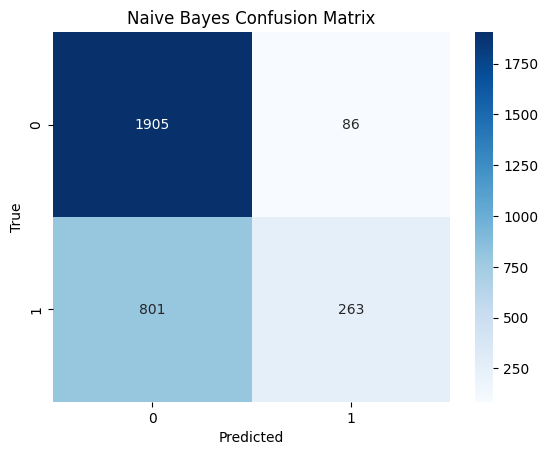

In [177]:
print("Naive Bayes (Implicit vs Others) Report:")
print(classification_report(y_test, y_pred_nb_1, digits=4))

cm_nb = confusion_matrix(y_test, y_pred_nb_1)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Naive Bayes (Implicit vs Others) Report(downsampling):
              precision    recall  f1-score   support

           0     0.8107    0.6454    0.7187      1991
           1     0.5197    0.7180    0.6030      1064

    accuracy                         0.6707      3055
   macro avg     0.6652    0.6817    0.6608      3055
weighted avg     0.7094    0.6707    0.6784      3055



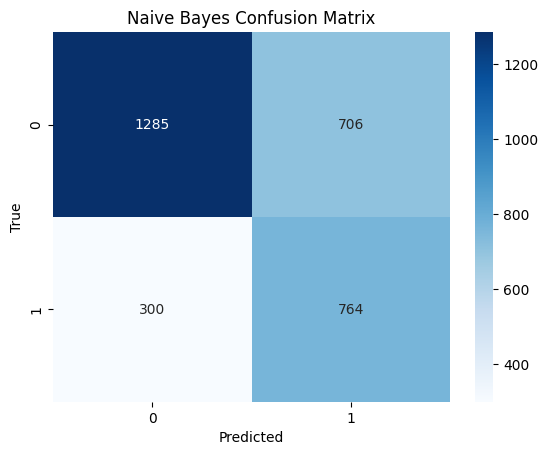

In [178]:
print("Naive Bayes (Implicit vs Others) Report(downsampling):")
print(classification_report(y_test, y_pred_nb_2, digits=4))

cm_nb = confusion_matrix(y_test, y_pred_nb_2)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The Naive Bayes baseline performs well at identifying the majority “other” class, achieving a very high recall of 0.95. However, its performance on implicit hate — the minority class — is extremely weak. Although precision for class 1 is moderate (0.75), recall drops to only 0.26, meaning the model misses more than 80% of implicit hate examples. This indicates that Naive Bayes relies heavily on surface-level lexical cues and cannot capture the subtle, context-dependent patterns that characterize implicit hate. As a result, the model is strongly biased toward predicting the majority class, leading to poor macro-F1 and ineffective minority-class detection.

**Although downsampling improves the recall of the implicit hate class, it comes at the cost of a substantial drop in overall accuracy (from 0.71 to 0.66).**

# Model 2: RNN - LSTM

In [179]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 20000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val_pad   = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

## Model Building

In [180]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC

# class weight(for imbalanced data)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights)}




In [181]:
EMBED_DIM = 64
LSTM_UNITS = 64

inputs = Input(shape=(MAX_LEN,))
x = Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM)(inputs)
x = Bidirectional(LSTM(LSTM_UNITS))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

bilstm_model = Model(inputs, outputs)
bilstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


### Train without class_weight

In [182]:
# train without class weight
history_rnn_1 = bilstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[es],
    verbose=1
)
y_pred_1 = bilstm_model.predict(X_test_pad)
y_pred_1 = (y_pred_1 >= 0.5).astype("int32").ravel()


Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6781 - auc: 0.6738 - loss: 0.6025 - precision: 0.6223 - recall: 0.1936 - val_accuracy: 0.7174 - val_auc: 0.7501 - val_loss: 0.5565 - val_precision: 0.6684 - val_recall: 0.3742
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7936 - auc: 0.8596 - loss: 0.4407 - precision: 0.7345 - recall: 0.6386 - val_accuracy: 0.7256 - val_auc: 0.7493 - val_loss: 0.5989 - val_precision: 0.6412 - val_recall: 0.4816
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8649 - auc: 0.9307 - loss: 0.3185 - precision: 0.8220 - recall: 0.7814 - val_accuracy: 0.7227 - val_auc: 0.7322 - val_loss: 0.7341 - val_precision: 0.6479 - val_recall: 0.4458
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


### Train with class_weight

In [183]:
history_rnn_2 = bilstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)
y_pred_2 = bilstm_model.predict(X_test_pad)
y_pred_2 = (y_pred_2 >= 0.5).astype("int32").ravel()

Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7831 - auc: 0.8653 - loss: 0.4592 - precision: 0.6572 - recall: 0.7893 - val_accuracy: 0.7178 - val_auc: 0.7481 - val_loss: 0.6140 - val_precision: 0.5992 - val_recall: 0.5721
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.8500 - auc: 0.9297 - loss: 0.3366 - precision: 0.7433 - recall: 0.8696 - val_accuracy: 0.7138 - val_auc: 0.7300 - val_loss: 0.7544 - val_precision: 0.6065 - val_recall: 0.5071
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


### Downsampling

In [184]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train_bal)

X_train_bal_seq = tokenizer.texts_to_sequences(X_train_bal)
X_test_bal_seq = tokenizer.texts_to_sequences(X_test)

X_train_bal_pad = pad_sequences(X_train_bal_seq, maxlen=MAX_LEN)
X_test_bal_pad = pad_sequences(X_test_bal_seq, maxlen=MAX_LEN)


In [185]:
inputs = Input(shape=(MAX_LEN,))
x = Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM)(inputs)
x = Bidirectional(LSTM(LSTM_UNITS))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

bilstm_model = Model(inputs, outputs)
bilstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# train without class weight
history_rnn_3 = bilstm_model.fit(
    X_train_bal_pad, y_train_bal,
    validation_data=(X_val_pad, y_val),
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[es],
    verbose=1
)
y_pred_3 = bilstm_model.predict(X_test_bal_pad)
y_pred_3 = (y_pred_3 >= 0.5).astype("int32").ravel()


Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6163 - auc: 0.6716 - loss: 0.6473 - precision: 0.6239 - recall: 0.5856 - val_accuracy: 0.5615 - val_auc: 0.5232 - val_loss: 0.7354 - val_precision: 0.3760 - val_recall: 0.3930
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7810 - auc: 0.8651 - loss: 0.4594 - precision: 0.7804 - recall: 0.7822 - val_accuracy: 0.5346 - val_auc: 0.5238 - val_loss: 0.8986 - val_precision: 0.3645 - val_recall: 0.4524
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8275 - auc: 0.9098 - loss: 0.3841 - precision: 0.8181 - recall: 0.8424 - val_accuracy: 0.5182 - val_auc: 0.5201 - val_loss: 1.1214 - val_precision: 0.3586 - val_recall: 0.4863
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## Evaluation

### Training curve

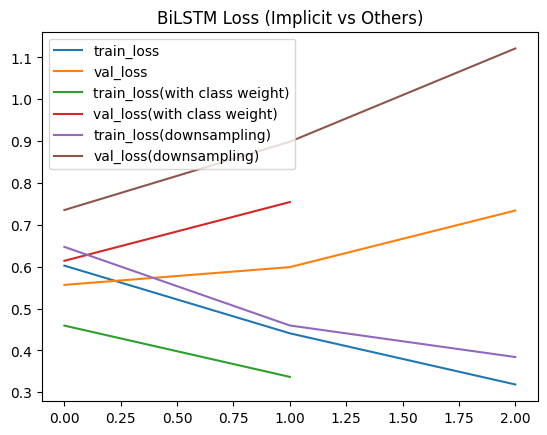

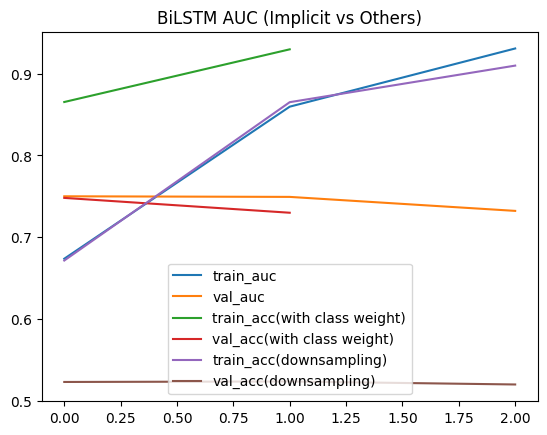

In [186]:
plt.plot(history_rnn_1.history['loss'], label='train_loss')
plt.plot(history_rnn_1.history['val_loss'], label='val_loss')
plt.plot(history_rnn_2.history['loss'], label='train_loss(with class weight)')
plt.plot(history_rnn_2.history['val_loss'], label='val_loss(with class weight)')
plt.plot(history_rnn_3.history['loss'], label='train_loss(downsampling)')
plt.plot(history_rnn_3.history['val_loss'], label='val_loss(downsampling)')
plt.legend()
plt.title("BiLSTM Loss (Implicit vs Others)")
plt.show()

plt.plot(history_rnn_1.history["auc"], label="train_auc")
plt.plot(history_rnn_1.history["val_auc"], label="val_auc")
plt.plot(history_rnn_2.history['auc'], label='train_acc(with class weight)')
plt.plot(history_rnn_2.history['val_auc'], label='val_acc(with class weight)')
plt.plot(history_rnn_3.history['auc'], label='train_acc(downsampling)')
plt.plot(history_rnn_3.history['val_auc'], label='val_acc(downsampling)')
plt.legend()
plt.title("BiLSTM AUC (Implicit vs Others)")
plt.show()


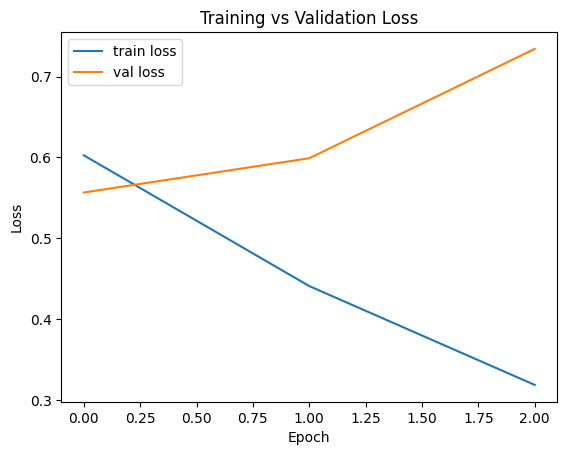

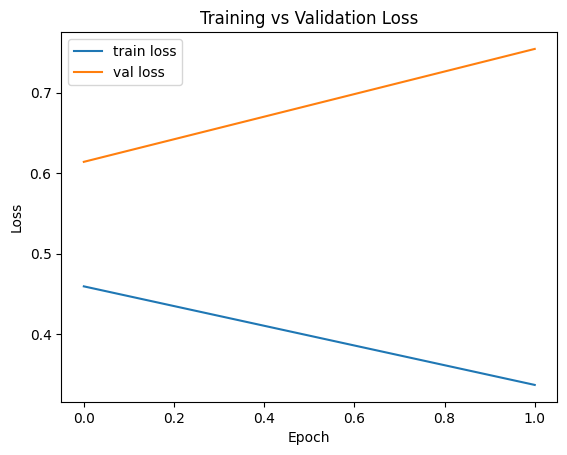

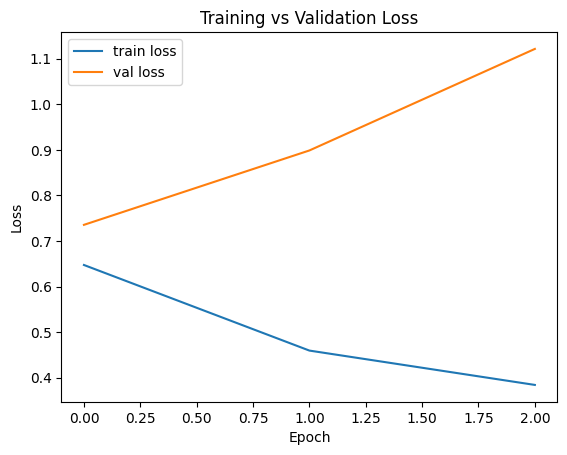

In [187]:
import matplotlib.pyplot as plt

def plot_train_val_loss(history):
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()


plot_train_val_loss(history_rnn_1)
plot_train_val_loss(history_rnn_2)
plot_train_val_loss(history_rnn_3)

The training and validation curves diverge very early (around 0.2–0.3 epoch), indicating that the model begins to overfit almost immediately.
This is expected given the small dataset size and the subtle nature of implicit hate.
Therefore, we rely on early stopping rather than manually tuning the epoch count, as training for a full epoch already exceeds the optimal point.

BiLSTM (Implicit vs Others) Report(without class weight):
              precision    recall  f1-score   support

           0     0.7354    0.9076    0.8125      1991
           1     0.6923    0.3891    0.4982      1064

    accuracy                         0.7270      3055
   macro avg     0.7139    0.6483    0.6553      3055
weighted avg     0.7204    0.7270    0.7030      3055



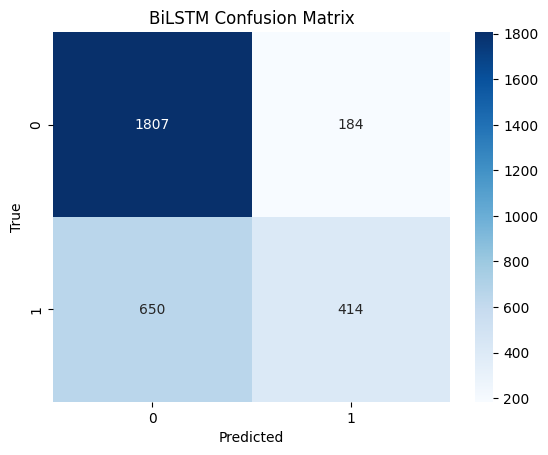

In [188]:
print("BiLSTM (Implicit vs Others) Report(without class weight):")
print(classification_report(y_test, y_pred_1, digits=4))

cm_imp = confusion_matrix(y_test, y_pred_1)
sns.heatmap(cm_imp, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

BiLSTM (Implicit vs Others) Report(with class weight):
              precision    recall  f1-score   support

           0     0.7770    0.7805    0.7788      1991
           1     0.5858    0.5808    0.5833      1064

    accuracy                         0.7110      3055
   macro avg     0.6814    0.6807    0.6810      3055
weighted avg     0.7104    0.7110    0.7107      3055



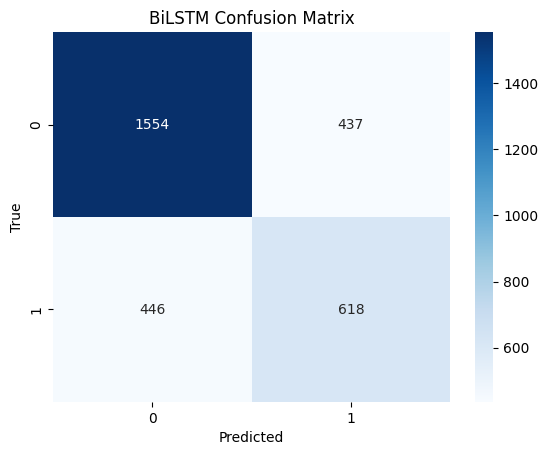

In [189]:
print("BiLSTM (Implicit vs Others) Report(with class weight):")
print(classification_report(y_test, y_pred_2, digits=4))

cm_imp = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm_imp, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

BiLSTM (Implicit vs Others) Report(downsampling):
              precision    recall  f1-score   support

           0     0.7738    0.7850    0.7794      1991
           1     0.5865    0.5705    0.5784      1064

    accuracy                         0.7103      3055
   macro avg     0.6801    0.6778    0.6789      3055
weighted avg     0.7085    0.7103    0.7094      3055



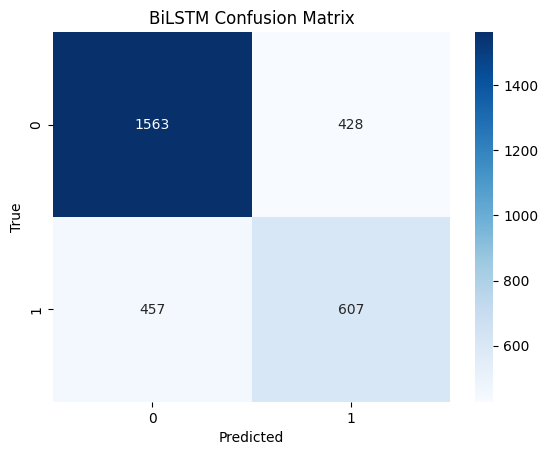

In [190]:
print("BiLSTM (Implicit vs Others) Report(downsampling):")
print(classification_report(y_test, y_pred_3, digits=4))

cm_imp = confusion_matrix(y_test, y_pred_3)
sns.heatmap(cm_imp, annot=True, fmt="d", cmap="Blues")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Applying class weights improves the model’s ability to detect implicit hate — the minority class — by substantially increasing recall (from 0.46 to 0.64) and improving the F1 score for class 1. This indicates that the baseline model was strongly biased toward the majority “other” class, and class weighting helps correct this imbalance by encouraging the network to pay more attention to subtle hateful content.

The overall accuracy drops slightly, which is expected: increasing sensitivity to minority samples comes at the cost of misclassifying more majority-class examples. However, for this task, detecting implicit hate is more important than optimizing global accuracy.

In summary, class weighting provides a meaningful but limited improvement — a step in the right direction, but insufficient on its own. The task remains challenging, and more advanced models (e.g., BERT) are likely required to capture deeper contextual cues.

Possible Reasons:

1. Implicit hate rarely contains explicit lexical cues
2. RNNs struggle with long-range or abstract semantic dependencies
3. Data imbalance amplifies RNN weaknesses
4. Vocabulary-based sequence models cannot detect paraphrasing or contextual shifts
5. Overfitting occurs easily due to small dataset + high model capacity

**Downsample and class_wight produce similar results for LSTM.**

# Model 3: BERT

## Setup

In [191]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [192]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2  # implicit vs others
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Data Preparation

In [193]:
class HateDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text  = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {
            "input_ids": enc["input_ids"].squeeze(0),       # (seq_len)
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }
        return item


In [194]:
MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = HateDataset(X_train, y_train, tokenizer, max_len=MAX_LEN)
test_dataset  = HateDataset(X_test,  y_test,  tokenizer, max_len=MAX_LEN)
val_dataset  = HateDataset(X_val,  y_val,  tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)
val_loader  = DataLoader(val_dataset,  batch_size=BATCH_SIZE, shuffle=False)


In [195]:
train_bal_dataset = HateDataset(X_train_bal, y_train_bal, tokenizer, max_len=MAX_LEN)

train_bal_loader = DataLoader(train_bal_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Model Training

### Original Dataset

In [196]:
num_epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)

best_val_loss = float("inf")
best_state_dict = None

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    model.train()
    total_train_loss = 0.0

    for batch in train_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Train loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Val loss:   {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_state_dict = model.state_dict()
        print(">>> New best model saved (based on val loss).")

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with val loss = {best_val_loss:.4f}")


Epoch 1/3


KeyboardInterrupt: 

In [169]:
import torch.nn.functional as F
model.eval()
all_preds = []
all_labels = []
all_probs  = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits 
        probs = F.softmax(logits, dim=1)[:, 1] 
        preds = torch.argmax(logits, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_test   = np.concatenate(all_labels)
y_pred_bert_1   = np.concatenate(all_preds)
y_prob_bert_1 = np.concatenate(all_probs)

print("BERT (Implicit vs Others) Report:")
print(classification_report(y_test, y_pred_1, digits=4))

cm_bert_1 = confusion_matrix(y_test, y_pred_1)
print("Confusion Matrix:\n", cm_bert_1)


BERT (Implicit vs Others) Report:
              precision    recall  f1-score   support

           0     0.7369    0.8877    0.8053      2654
           1     0.6598    0.4073    0.5037      1419

    accuracy                         0.7204      4073
   macro avg     0.6984    0.6475    0.6545      4073
weighted avg     0.7101    0.7204    0.7002      4073

Confusion Matrix:
 [[2356  298]
 [ 841  578]]


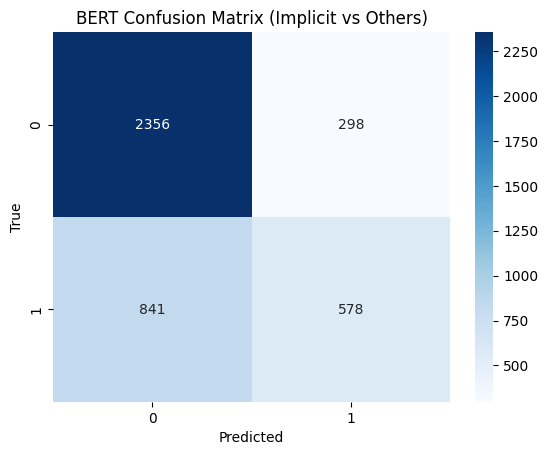

In [171]:
sns.heatmap(cm_bert_1, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Confusion Matrix (Implicit vs Others)")
plt.show()


### Downsampling

In [172]:
num_epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)

best_val_loss = float("inf")
best_state_dict = None

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    model.train()
    total_train_loss = 0.0

    for batch in train_bal_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Train loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Val loss:   {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_state_dict_2 = model.state_dict()
        print(">>> New best model saved (based on val loss).")

if best_state_dict_2 is not None:
    model.load_state_dict(best_state_dict_2)
    print(f"\nLoaded best model with val loss = {best_val_loss:.4f}")


Epoch 1/3


KeyboardInterrupt: 

In [ ]:
import torch.nn.functional as F
model.eval()
all_preds = []
all_labels = []
all_probs  = []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits 
        probs = F.softmax(logits, dim=1)[:, 1] 
        preds = torch.argmax(logits, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_test   = np.concatenate(all_labels)
y_pred_bert_2   = np.concatenate(all_preds)
y_prob_bert_2 = np.concatenate(all_probs)

print("BERT (Implicit vs Others) Report:")
print(classification_report(y_test, y_pred_2, digits=4))

cm_bert_2 = confusion_matrix(y_test, y_pred_2)
print("Confusion Matrix:\n", cm_bert_2)

BERT (Implicit vs Others) Report:
              precision    recall  f1-score   support

           0     0.8234    0.7555    0.7880      2654
           1     0.6038    0.6970    0.6470      1419

    accuracy                         0.7351      4073
   macro avg     0.7136    0.7262    0.7175      4073
weighted avg     0.7469    0.7351    0.7389      4073

Confusion Matrix:
 [[2005  649]
 [ 430  989]]


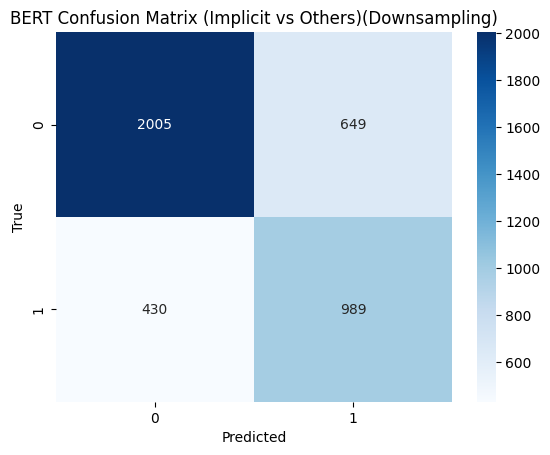

In [ ]:
sns.heatmap(cm_bert_2, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("BERT Confusion Matrix (Implicit vs Others)(Downsampling)")
plt.show()

# Final Evaluation

## Original Dataset

### ROC Curve

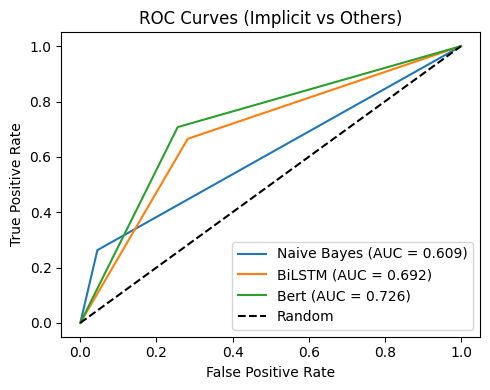

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, prob_dict):
    """
    """
    plt.figure(figsize=(5, 4))
    for name, y_pred in prob_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Implicit vs Others)")
    plt.legend()
    plt.tight_layout()
    plt.show()

pred_dict = {
    "Naive Bayes": y_pred_nb_1,
    "BiLSTM": y_pred_2,
    "Bert": y_pred_bert_1,
}
plot_roc_curves(y_test, pred_dict)

### PR Curve

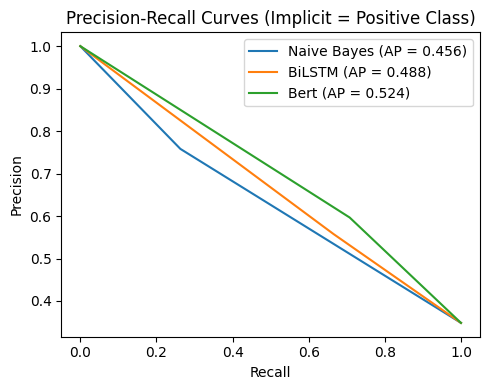

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(y_true, pred_dict):
    plt.figure(figsize=(5, 4))
    for name, y_pred in pred_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
        ap = average_precision_score(y_true, y_pred)
        plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (Implicit = Positive Class)")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_pr_curves(y_test, pred_dict)

### Error Example

In [ ]:
test_df = pd.DataFrame({
    "text": X_test,
    "label": y_test,
})

def get_error_examples(df, y_true, y_pred, text_col="text"):
    df = df.copy()
    df["y_true"] = y_true
    df["y_pred"] = y_pred

    # False Negatives
    fn = df[(df["y_true"] == 1) & (df["y_pred"] == 0)]

    # False Positives
    fp = df[(df["y_true"] == 0) & (df["y_pred"] == 1)]

    return fn, fp

fn_nb, fp_nb       = get_error_examples(test_df, y_test, y_pred_nb_1)
fn_rnn, fp_rnn     = get_error_examples(test_df, y_test, y_pred_2)
fn_bert, fp_bert     = get_error_examples(test_df, y_test, y_pred_bert_1)



In [121]:
def show_examples(df, n=5, title="Examples"):
    print(f"\n===== {title} (n={min(n, len(df))}) =====")
    for i, row in df.sample(min(n, len(df)), random_state=42).iterrows():
        print(f"[true={row['y_true']}, pred={row['y_pred']}]")
        print(row["text"])
        print("-" * 50)
        
show_examples(fn_bert, n=5, title="BiLSTM False Negatives")
show_examples(fp_bert, n=5, title="BiLSTM False Positives")

show_examples(fn_nb,  n=3, title="NB False Negatives")
show_examples(fp_nb,  n=3, title="NB False Positives")

show_examples(fn_rnn, n=3, title="BiLSTM False Negatives")
show_examples(fp_rnn, n=3, title="BiLSTM False Positives")



===== BiLSTM False Negatives (n=5) =====
[true=1, pred=0]
caleb russell inspires bus ad kill white people bus
--------------------------------------------------
[true=1, pred=0]
people speaking dangers islam west
--------------------------------------------------
[true=1, pred=0]
bad unless poor white supremacist
--------------------------------------------------
[true=1, pred=0]
fave question ask counter protesters majority white hate white people
--------------------------------------------------
[true=1, pred=0]
wow diversity colors races doctors engineers amazing
--------------------------------------------------

===== BiLSTM False Positives (n=5) =====
[true=0, pred=1]
make sense share alt right anti semitic racist views looking tl
--------------------------------------------------
[true=0, pred=1]
having say response twitter accusations don't hate whites white friends white women i've dated white i'm yuuge whites whites love whites make best beer
-------------------------------

On the original, highly imbalanced data, even BERT struggles to capture implicit hate reliably.
When we rebalance the training set via undersampling, BERT’s recall on implicit hate increases substantially, but this comes at the cost of more false positives and reduced exposure to the full diversity of non-hate language.